# Naive Bayes classifier for classifying AI-generated tweet and human-generated tweet


## Loading Datasets

In [63]:
import pandas as pd
train_df = pd.read_csv('dataset/train.csv')
val_df = pd.read_csv('dataset/validation.csv')
test_df = pd.read_csv('dataset/test.csv')

In [64]:
train_df.head()

,screen_name,text,account.type,class_type
0,imranyebot,YEA now that note GOOD,bot,others
1,zawvrk,Listen to This Charming Man by The Smiths htt...,human,human
2,zawarbot,wish i can i would be seeing other hoes on the...,bot,others
3,ahadsheriffbot,The decade in the significantly easier schedul...,bot,others
4,kevinhookebot,"""Theim class=\""alignnone size-full wp-image-60...",bot,rnn


## Preprocessing the Text Data

In [65]:
import re
from nltk.corpus import stopwords
import spacy

if not spacy.util.is_package('en_core_web_sm'):
    spacy.cli.download("en_core_web_sm")

nlp = spacy.load('en_core_web_sm')


def preprocess_text(text):
    """ Method to clean reviews from noise and standardize text across the different classes.
    Arguments
    ---------
    text : String
        Text to clean
    Returns
    -------
    text : String
        Cleaned text
    """
    stop_words = set(stopwords.words('english'))
    
    text = text.lower() # Convert text to lowercase
    text = text.replace('\n', ' ') # Remove newline characters and extra spaces
    text = re.sub(r'http\S+', '', text) # Remove URLs
    text = re.sub(r'[^\w\s]', ' ', text) # Remove punctuation and special characters
    text = re.sub(r'\d+', ' ', text) # Remove digits
    text = ' '.join([word for word in text.split() if word not in stop_words]) # Remove stopwords
    text = ' '.join( [token.lemma_ for token in nlp(text)]) # Lemmatize text

    return text

In [66]:
train_df['text'] = train_df['text'].apply(lambda x: preprocess_text(x))
val_df['text'] = val_df['text'].apply(lambda x: preprocess_text(x))
test_df['text'] = test_df['text'].apply(lambda x: preprocess_text(x))

In [67]:
train_df.head()

,screen_name,text,account.type,class_type
0,imranyebot,yea note good,bot,others
1,zawvrk,listen charming man smith,human,human
2,zawarbot,wish would see hoe bad part,bot,others
3,ahadsheriffbot,decade significantly easy schedule like h,bot,others
4,kevinhookebot,theim class alignnone size full wp image src a...,bot,rnn


## Preparing the Features and Labels

In [68]:
X_train = train_df['text']
y_train = train_df['account.type']

X_val = val_df['text']
y_val = val_df['account.type']

X_test = test_df['text']
y_test = test_df['account.type']

## Vectorizing the Text Data

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

X_train = tfidf_vectorizer.fit_transform(train_df['text'])
y_train = train_df['account.type']

X_val = tfidf_vectorizer.transform(val_df['text'])
y_val = val_df['account.type']

X_test = tfidf_vectorizer.transform(test_df['text'])
y_test = test_df['account.type']

In [70]:
X_train.shape, X_val.shape, X_test.shape

((20712, 25441), (2302, 25441), (2558, 25441))

## Implementation the Naive Bayes Classifier

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix


class NaiveBayesClassifier:
    def __init__(self, alpha=1):
        self.alpha = alpha
        self.class_probs = None
        self.word_probs = None

    def fit(self, X, y):
        num_docs, vocab_size = X.shape
        unique_classes, class_counts = np.unique(y, return_counts=True)
        self.class_probs = class_counts / num_docs  # P(c)
        self.word_probs = np.zeros((len(unique_classes), vocab_size))

        for i, c in enumerate(unique_classes):
            class_docs = X[y == c]
            total_words = class_docs.sum()
            self.word_probs[i, :] = (class_docs.sum(axis=0) + self.alpha) / (
                total_words + self.alpha * vocab_size
            )

    def predict(self, X):
        log_class_probs = np.log(self.class_probs)
        log_word_probs = np.log(self.word_probs)
        log_likelihoods = X @ log_word_probs.T + log_class_probs
        return np.argmax(log_likelihoods, axis=1)

## Finding best alpha from validation set

In [94]:
best_alpha = 0
best_val_accuracy = 0
label_map = {0: "bot", 1: "human"}

for alpha in np.arange(0.0, 5.0, 0.05):
    nb_classifier = NaiveBayesClassifier(alpha=alpha)
    nb_classifier.fit(X_train, y_train)
    y_val_pred = nb_classifier.predict(X_val)
    y_val_pred_labels = [label_map[pred] for pred in y_val_pred]
    accuracy_val = np.mean(y_val_pred_labels == y_val)
    if accuracy_val > best_val_accuracy:
        best_val_accuracy = accuracy_val
        best_alpha = alpha

print(f"Best alpha from validation set: {best_alpha}")

/var/folders/l8/sbknnyv96tz26jxsvt8xvxq00000gn/T/ipykernel_8882/3250028371.py:55: RuntimeWarning: divide by zero encountered in log
  log_word_probs = np.log(self.word_probs)
/var/folders/l8/sbknnyv96tz26jxsvt8xvxq00000gn/T/ipykernel_8882/3250028371.py:61: RuntimeWarning: invalid value encountered in multiply
  log_likelihoods[i] = np.sum(log_word_probs * doc, axis=1) + log_class_probs


Best alpha from validation set: 0.25


In [95]:
nb_classifier = NaiveBayesClassifier(alpha=0.25)
nb_classifier.fit(X_train, y_train)
label_map = {0: 'bot', 1: 'human'}

y_test_pred = nb_classifier.predict(X_test)
y_test_pred_labels = [label_map[pred] for pred in y_test_pred]
print("Classification Report on Test Set:")
print(classification_report(y_test, y_test_pred_labels))


Classification Report on Test Set:
              precision    recall  f1-score   support

         bot       0.72      0.64      0.68      1280
       human       0.67      0.74      0.71      1278

    accuracy                           0.69      2558
   macro avg       0.70      0.69      0.69      2558
weighted avg       0.70      0.69      0.69      2558



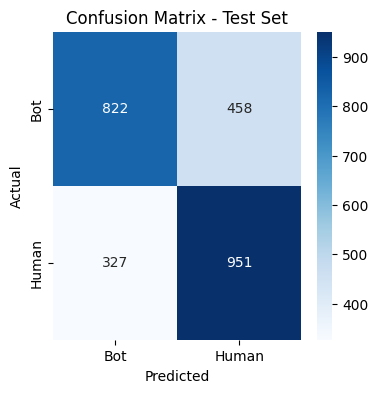

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

cm_test = confusion_matrix(y_test, y_test_pred_labels)

plt.figure(figsize=(4, 4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Bot', 'Human'], yticklabels=['Bot', 'Human'])
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Testing different values of alpha

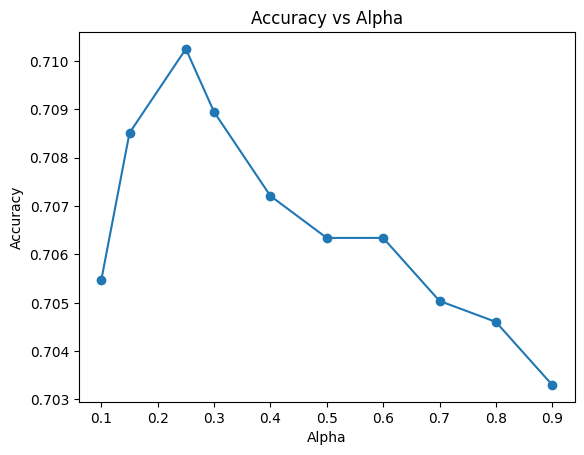

In [98]:
alphas = [0.1, 0.15, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
accuracies = []

for alpha in alphas:
    nb_classifier = NaiveBayesClassifier(alpha=alpha)
    nb_classifier.fit(X_train, y_train)
    y_val_pred = nb_classifier.predict(X_val)
    y_val_pred_labels = [label_map[pred] for pred in y_val_pred]
    accuracy = np.mean(y_val_pred_labels == y_val)
    accuracies.append(accuracy)
    
plt.plot(alphas, accuracies, marker='o')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Alpha')
plt.show()